In [1]:
import requests
import pytz
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from cycler import cycler
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from urllib3.exceptions import InsecureRequestWarning

In [8]:
warnings.simplefilter("ignore", InsecureRequestWarning)
url = "https://publicationtool.jao.eu/core/api/data/finalComputation"
base_params = {
    "Filter": '{"Tso":["10XSI-ELES-----1"]}',
    "Skip": 0,
    "Take": 100
}

all_data = []

# start_time = datetime(2025, 1, 10, 23, 0, 0)
# end_time = datetime(2025, 1, 11, 23, 0, 0)

start_time = datetime(2024, 12, 27, 23, 0, 0)
end_time = datetime(2024, 12, 28, 00, 0, 0)

current_time = start_time
while current_time < end_time:
    from_utc = current_time.strftime("%Y-%m-%dT%H:%M:%S.000Z")
    to_utc = (current_time + timedelta(hours=1)).strftime("%Y-%m-%dT%H:%M:%S.000Z")
    
    params = base_params.copy()
    params["FromUtc"] = from_utc
    params["ToUtc"] = to_utc

    try:
        response = requests.get(url, params=params, verify=False)
        response.raise_for_status()
        data = response.json()
        if 'data' in data:
            all_data.extend(data['data'])
        else:
            print(f"No 'data' key found in response for {from_utc} to {to_utc}.")
    except requests.exceptions.RequestException as e:
        print(f"An error occurred for {from_utc} to {to_utc}: {e}")

    current_time += timedelta(hours=1)

if all_data:
    df = pd.DataFrame(all_data)
else:
    print("No data was retrieved.")

# Convert to Ljubljana time zone (Europe/Ljubljana)
df['dateTimeUtc'] = pd.to_datetime(df['dateTimeUtc'], utc=True)
df['dateTimeUtc'] = df['dateTimeUtc'].dt.tz_convert(pytz.timezone('Europe/Ljubljana'))
df['dateTimeUtc'] = df['dateTimeUtc'].dt.tz_localize(None)

In [9]:
df = df.drop(['id','tso', 'cneEic','hubFrom','hubTo','substationFrom','substationTo', 'contingencies','elementType','fmaxType','cneStatus', 'presolved','imax','u','justification','contTso','ltaMargin','minRamFactor'], axis=1)
df = df.iloc[:, :-14]

df['contName'] = df['contName'].astype(str)
df['contName'] = df['contName'].apply(lambda x: ' '.join(x.split()[4:]) if len(x.split()) > 6 else x)
df['MACZT'] = (df['fmax'] - df['frm'] - df['fall'] + df['amr'] - df['iva'])/df['fmax']*100
df['RAM_calc'] = df['fmax'] - df['frm'] - df['fall'] + df['amr'] - df['iva']

df['contName'] = df['contName'].replace('None', 'BASECASE')
df['direction'] = df['direction'].apply(lambda x: f"({x})")
df['contName'] = df['contName'].replace('kV Cirkovce - Zerjavinec', '400 kV Cirkovce - Zerjavinec')
df['contName'] = df['contName'].replace('Divaca - Pehlin', '220 kV Divaca - Pehlin')
df['contName'] = df['contName'].replace('Bericevo-Divaca', '400 kV Bericevo - Divaca')
df['cneName'] = df['cneName'].replace('Cirkovce - Heviz', '400 kV Cirkovce - Heviz')

df['contName'] = df['contName'].apply(lambda x: f"(N-1) {x}" if x != 'BASECASE' else x)
df['info'] = df['cneName'] + ' ' + df['direction'] + ' / ' + df['contName']
df = df.drop(['cneName','direction','contName'], axis=1)
df['info'] = df['info'].apply(lambda x: x.replace(" / ", "\n") if " / " in x else x)

# df = df[df['iva'] > 0]
# df = df[df['amr'] > 0]
# df = df[df['MACZT'] < 70]
df

,dateTimeUtc,ram,minRamTarget,fmax,frm,frefInit,fnrao,fref,fcore,fall,fuaf,amr,cva,iva,ftotalLtn,fltn,MACZT,RAM_calc,info
0,2024-12-28 01:00:00,1258.0,0.732,1330.0,133.0,-168.0,-1.0,-167.0,-77.0,-34.0,-43.0,0.0,0.0,0.0,-61.0,16.0,92.556391,1231.0,400 kV Maribor - Kainachtal 1 (DIRECT)\nBASECASE
1,2024-12-28 01:00:00,1301.0,0.756,1330.0,133.0,-287.0,-1.0,-286.0,-132.0,-58.0,-74.0,0.0,0.0,0.0,-104.0,28.0,94.360902,1255.0,400 kV Maribor - Kainachtal 1 (DIRECT)\n(N-1)...
2,2024-12-28 01:00:00,1281.0,0.732,1330.0,133.0,-209.0,-1.0,-208.0,-103.0,-60.0,-43.0,0.0,0.0,0.0,-84.0,19.0,94.511278,1257.0,400 kV Maribor - Kainachtal 1 (DIRECT)\n(N-1)...
3,2024-12-28 01:00:00,1258.0,0.732,1330.0,133.0,-168.0,-1.0,-167.0,-77.0,-34.0,-43.0,0.0,0.0,0.0,-61.0,16.0,92.556391,1231.0,400 kV Maribor - Kainachtal 2 (DIRECT)\nBASECASE
4,2024-12-28 01:00:00,1301.0,0.756,1330.0,133.0,-287.0,-1.0,-286.0,-132.0,-58.0,-74.0,0.0,0.0,0.0,-104.0,28.0,94.360902,1255.0,400 kV Maribor - Kainachtal 2 (DIRECT)\n(N-1)...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2024-12-28 01:00:00,277.0,0.664,304.0,30.0,-13.0,0.0,-13.0,18.0,7.0,11.0,0.0,0.0,0.0,-3.0,-21.0,87.828947,267.0,Podlog - Zerjavinec (OPPOSITE)\n(N-1) 400 kV ...
68,2024-12-28 01:00:00,274.0,0.657,304.0,30.0,-8.0,0.0,-8.0,22.0,9.0,13.0,0.0,0.0,0.0,0.0,-22.0,87.171053,265.0,Podlog - Zerjavinec (OPPOSITE)\n(N-1) 400 kV ...
69,2024-12-28 01:00:00,274.0,0.657,304.0,30.0,-8.0,0.0,-8.0,22.0,9.0,13.0,0.0,0.0,0.0,0.0,-22.0,87.171053,265.0,Podlog - Zerjavinec (OPPOSITE)\n(N-1) 400 kV ...
70,2024-12-28 01:00:00,280.0,0.661,304.0,30.0,-14.0,0.0,-14.0,16.0,4.0,12.0,0.0,0.0,0.0,-6.0,-22.0,88.815789,270.0,Podlog - Zerjavinec (OPPOSITE)\n(N-1) 400 kV ...


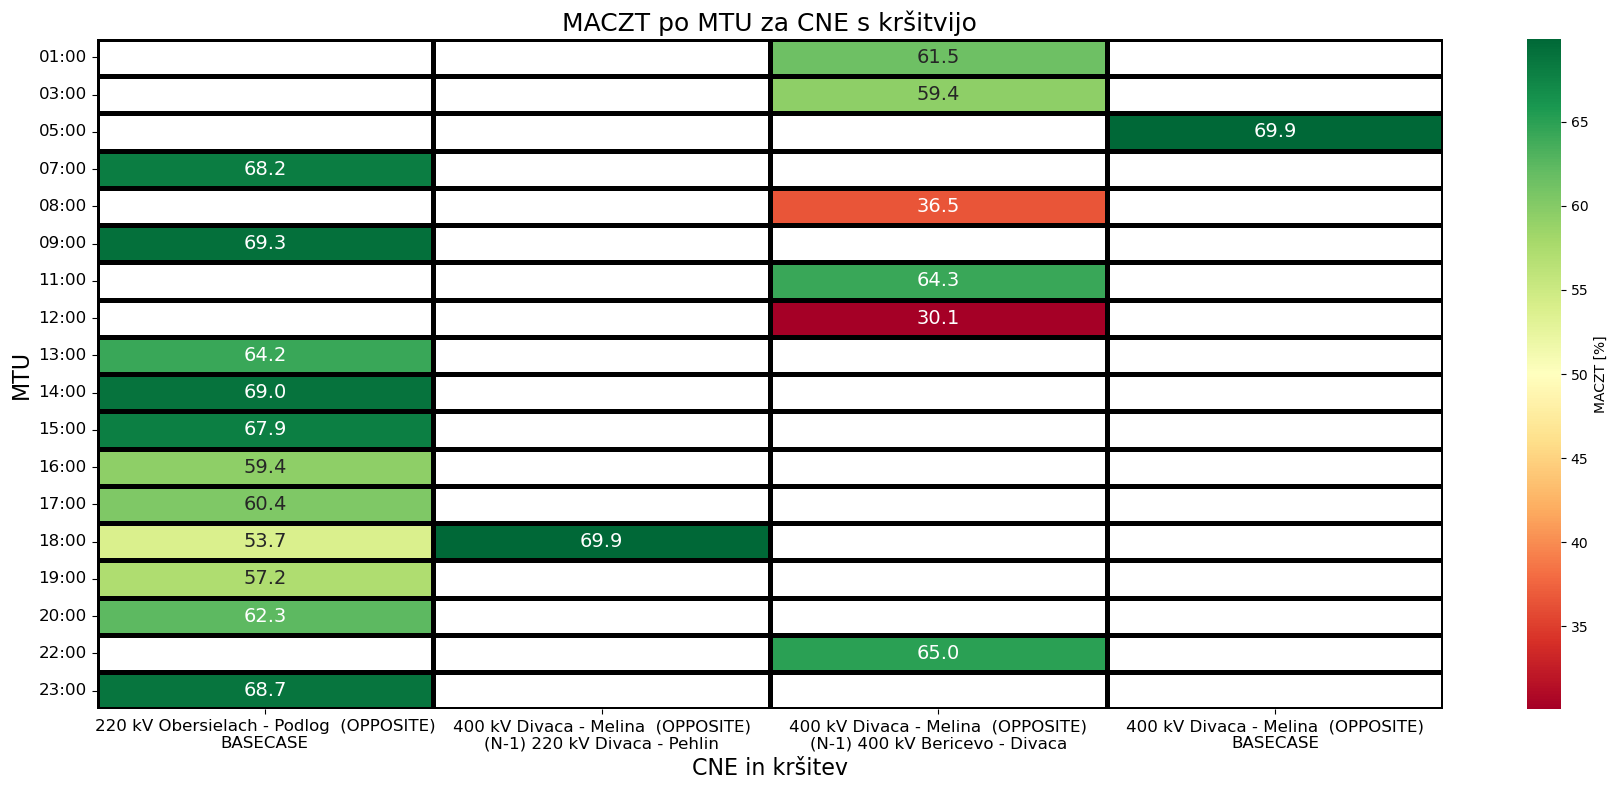

In [15]:
df['Hour_Minute'] = df['dateTimeUtc'].dt.strftime('%H:%M')

heatmap_data = df.pivot_table(
    columns='info',
    index='Hour_Minute',
    values='MACZT',  # The data to be visualized (can be counts or another metric)
    aggfunc='sum'  # Use 'sum', 'mean', etc., depending on your needs
)

# Define font sizes in one place
font_sizes = {
    "title": 18,
    "labels": 16,
    "ticks": 12,
    "annot": 14  # For annotations in the heatmap
}

# Plot the heatmap
plt.figure(figsize=(18, 8))
sns.heatmap(
    heatmap_data,
    cmap="RdYlGn",
    annot=True,
    fmt=".1f",
    linewidths=2.5,
    linecolor='black',
    cbar_kws={'label': 'MACZT [%]'},
    annot_kws={'size': font_sizes["annot"]}  # Font size for annotations
)
plt.title("MACZT po MTU za CNE s kršitvijo", fontsize=font_sizes["title"])
plt.xlabel("CNE in kršitev", fontsize=font_sizes["labels"])
plt.ylabel("MTU", fontsize=font_sizes["labels"])
plt.xticks(rotation=0, fontsize=font_sizes["ticks"])
plt.yticks(rotation=0, fontsize=font_sizes["ticks"])
plt.tight_layout()
plt.show()


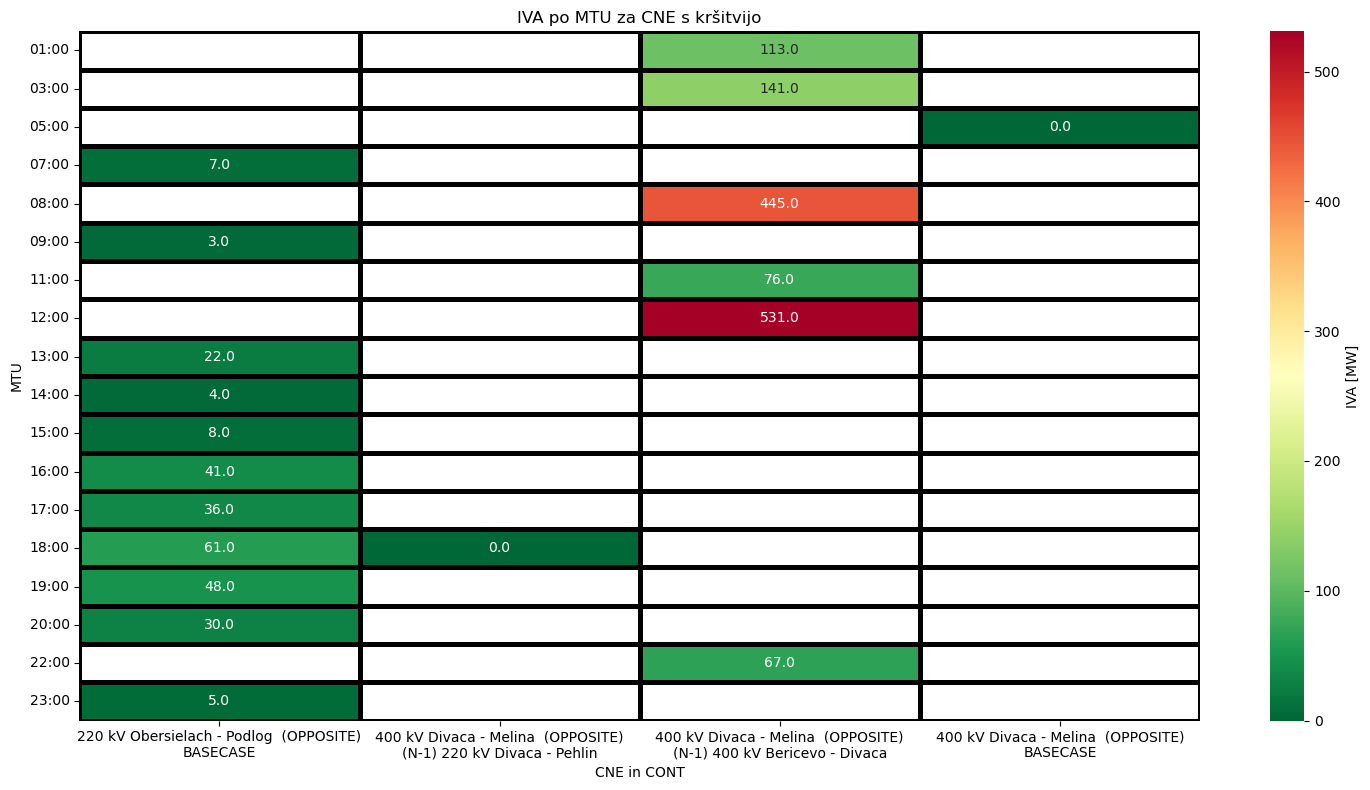

In [5]:
df['Hour_Minute'] = df['dateTimeUtc'].dt.strftime('%H:%M')

heatmap_data = df.pivot_table(
    columns='info',
    index='Hour_Minute',
    values='iva',  # The data to be visualized (can be counts or another metric)
    aggfunc='sum'  # Use 'sum', 'mean', etc., depending on your needs
)

# Plot the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_data, cmap="RdYlGn_r", annot=True, fmt=".1f",  linewidths=2.5, linecolor='black',cbar_kws={'label': 'IVA [MW]'})
plt.title("IVA po MTU za CNE s kršitvijo")
plt.xlabel("CNE in CONT")
plt.ylabel("MTU")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()